# Fast Tempering Replica Exchange SGLD (f-reSGLD)

We are now ready to explore an advanced algorithm, f-reSGLD. The principal development in this algorithm in Li et al. (2023) includes a bias correction term and an updated swapping rate.

We will start directly using estimated gradient. In this algorithm, both the gradient and the energy function values are estimated. For easiness of analysis, we for now simulate the estimated values individually (as opposed to using a finite difference scheme for estimated gradient).

In [1]:
# general imports
import numpy
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x = numpy.linspace(-2, 0.75, 1000)
f = lambda x : x**2 - numpy.cos(numpy.pi*x) + x
f_prime_exact = lambda x : 2*x + numpy.pi * numpy.sin(numpy.pi*x) + 1
f_prime_fin_diff = lambda x, g : (g(x+0.0001) - g(x-0.0001)) / (2*0.0001) 
s_log_sq = lambda x : 1 / (numpy.log(2*x+1)+5)**2

## Exact bias correction in one chain

Recall the old updating scheme:

$$
    \hat{\theta}_{k+1} = \hat{\theta}_k - \eta_k \hat{\nabla U}(\theta_k) + \sqrt{2 \eta_k \tau}\xi_k
$$

Li et al. (2023) added a delicate touch on the random noise term in LD updating scheme. The goal is to suppress bias generated by estimation of the gradient. Suppose the gradient estimator obeys $\hat{\nabla U}(\theta) \sim N(\nabla U(\theta), s^2)$, we define positive $c_k(\theta)$ (associated with step number $k$ and sampled $\theta$): $$c_k^2 = \tau \eta_k - \frac{1}{2} \eta_k^2 s^2$$

Then we define a new updating scheme:

$$
    \hat{\theta}_{k+1} = \hat{\theta}_k - \eta_k \hat{\nabla U}(\theta_k) + \sqrt{2} c_k(\theta_k) \xi_k
$$

In the above scheme, though the gradient estimator produces an error, the relation between $c_k$ and $s$ should somehow correct this error. We demonstrate this below.

In [3]:
n = 1000
t = 0.5
guess = -1.3

def bias_corr_one_chain_compare(f, f_prime, N, temp, step, x_0, sigma_grad = 1, limit = None):
    '''
    Applies m-reSGLD on designated function
    
    Parameters:
     f: exact energy function
     f_prime: exact gradient of energy function
     N: number of iterations
     temp: temperature for simulation
     step: step size, as a function of iteration count, must go to zero
     x_0: initial guess
     limit: a range optinally enforced on x; if x is out of range, then it's forced to the lower or upper bound
     sigma_grad: s.d. used for gradient estimator, default 1
     
    Returns: two numpy arrays of sampled x's, one based on exact update, one based on bias correction update
    '''
    
    chain_exact = numpy.empty(N)
    chain_correction = numpy.empty(N)
    chain_exact[0] = x_0
    chain_correction[0] = x_0
    error = numpy.empty(N)
    
    c = lambda k : numpy.sqrt(temp * step(k) - 0.5 * (step(k)**2) * (sigma_grad**2))
    
    for k in range(N-1):
        rand = numpy.random.normal(0,1)
        
        chain_exact[k+1] = chain_exact[k] - f_prime(chain_exact[k]) * step(k) + \
                           numpy.sqrt(2 * step(k) * temp) * rand
        chain_correction[k+1] = chain_correction[k] -\
                                numpy.random.normal(f_prime(chain_correction[k]), sigma_grad) * step(k) + \
                                numpy.sqrt(2) * c(k) * rand
        error[k+1] = abs(chain_exact[k+1] - chain_correction[k+1])
        if limit != None:
            if  x_new > limit[1]:
                x_new = limit[1]
            elif x_new < limit[0]:
                x_new = limit[0]
    
    return (chain_exact, chain_correction, error)

exact, correction, error = bias_corr_one_chain_compare(f, f_prime_exact, n, t, s_log_sq, guess)

print("max deviation from exact update: ", max(error))

max deviation from exact update:  0.9152419427620702


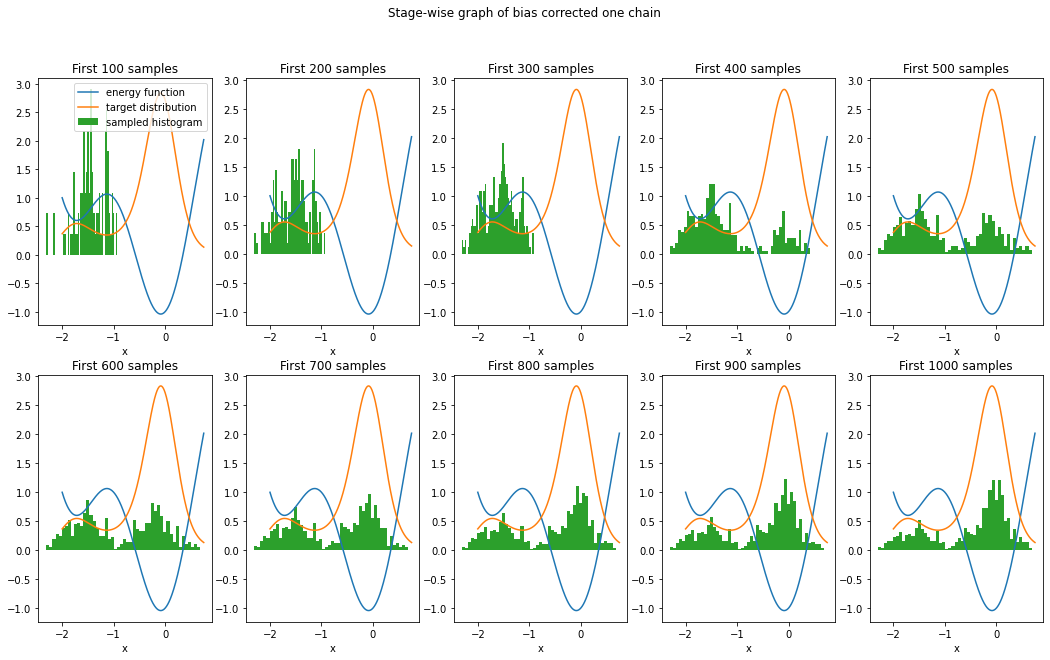

In [4]:
def single_chain_stagewise_graph(x, f, chain, title, swaps = None):
    """
    Parameters:
    x: interval in which the function is plotted
    f: the function on which LD was done
    chain: result of samples from the algorithm
    title: name of algorithm, see code below
    swaps: a list of indices where two chains swapped, optional
    """
    
    fig = plt.figure(figsize=(18, 10))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1)
        ax.plot(x, f(x), label = "energy function")
        ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
        ax.hist(chain[:len(chain)*(i+1)//10], bins = 50, density = True, label = "sampled histogram")
        #the line below is most useful for small number of iterations
        #ax.plot(chain[:len(chain)*(i+1)//10], f(chain[:len(chain)*(i+1)//10]), 'bx', label = "sampled x")
        if swaps != None:
            for idx in swaps:
                if idx < len(chain)*(i+1) // 10 and idx >= len(chain)*(i) // 10:
                    ax.plot(chain[idx], f(chain[idx]), 'ko')
                    ax.plot(chain[idx+1], f(chain[idx+1]), 'ro')
                    dx = chain[idx+1] - chain[idx]
                    dy = f(chain[idx+1]) - f(chain[idx])
                    ax.arrow(chain[idx], f(chain[idx]), dx, dy, head_width = 0.15)
        if i == 0:
            ax.legend()
        ax.set_xlabel("x")
        ax.set_title("First {n} samples".format(n=len(chain)*(i+1)//10))
    fig.suptitle("Stage-wise graph of {t}".format(t = title, fontsize=14))
    plt.show()
    if swaps != None:
        print("Swap occured at i = :", swaps)

single_chain_stagewise_graph(x, f, correction, "bias corrected one chain")

Note: we were not able to reproduce the "exact" update achieved by bias correction. Nor does it seem possible to do so even if we had followed everything in the paper. 

Next we simulate two chains with the updated swapping rate.

## Two chain with updated swapping rate

Key points:
- energy function values and gradients are all estimated independently
- each chain uses the bias correction mechanism; we assume we know the exact s.d. of all gradient estimators
- the new swapping rate is $$p = a \eta_k \min{1, S(\theta^{(1)}_k, \theta^{(2)}_k)}$$ where $$S(\theta^{(1)}, \theta^{(2)}) = \exp \{ \tau_\delta [\hat{U}_1(\theta^{(1)}) - \hat{U}_2(\theta^{(2)}) - \frac{1}{2}\tau_\delta (\sigma_1^2(\theta^{(1)}) +  \sigma_2^2(\theta^{(2)}))]\}$$
- the advantage of the new swappiing rate is that in each computation, one only computes both energy function estimators once instead of twice (as in m-reSGLD). 
- instead of getting a weighted sum of energy function differences as in m-reSGLD, the variables generated by the first chain will only be used by the first chain's estimator, same with second chain.
- how should one tune the two estimators? or why should we have two estimators in the first place, if none of them are in anyway related to the corresponding gradient estimators?
- in the 2023 paper, the variance of all estimators are presented as dependent on the variable generated ($\theta$). we only use constant variance here. Note that in numerical experiments it looks like the dependence on variance is only used when one updates estimated variance from newly generated $\theta$.
- do two chains have the same temperature? confusion on c_k

Swap occurred 1 times


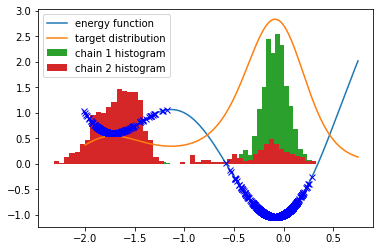

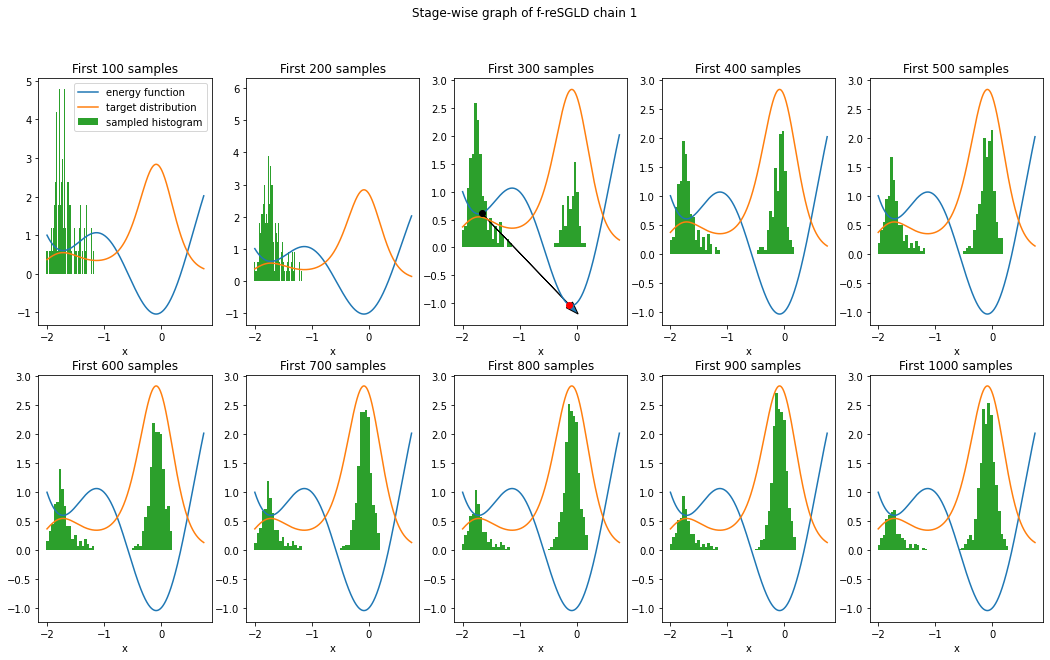

Swap occured at i = : [205]


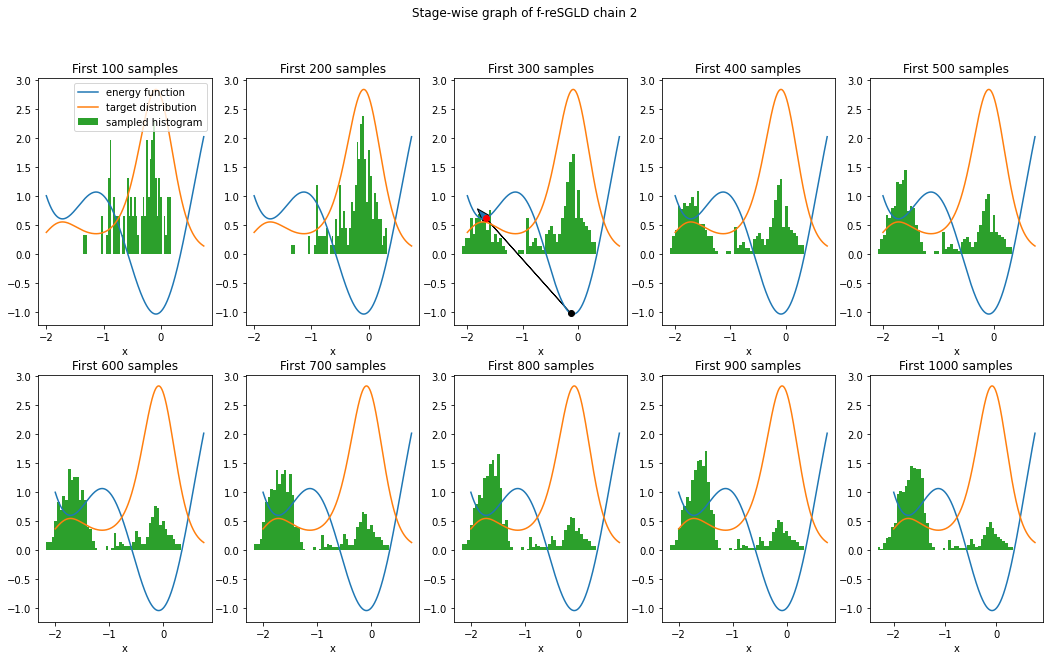

Swap occured at i = : [205]


In [20]:
def f_reSGLD_normal(f, f_prime, N, temp_1, temp_2, step, x_0, \
                    a = 0.5, sigma_1 = 0.25, sigma_2 = 0.5, sigma_grad_1 = 1, sigma_grad_2 = 1, limit = None):
    '''
    Applies m-reSGLD on designated function
    
    Parameters:
     f: exact energy function
     f_prime: exact gradient of energy function
     N: number of iterations
     temp_1: used for low temperature chain
     temp_2: used for high temperature chain
     step: step size, as a function of iteration count, must go to zero
     x_0: initial guess
     limit: a range optinally enforced on x; if x is out of range, then it's forced to the lower or upper bound
     a: parameter relating to swapping probability of the two chains, default 0.5
     sigma_1: standard deviation used for first energy function estimator, default 1
     sigma_2: s.d. for second energy function estimator, default 1
     sigma_grad_1: s.d. used for first gradient estimator, default 1
     sigma_grad_2: s.d. used for second gradient estimator, default 1
     
    Returns: two numpy arrays of sampled x's, and an array of indices where swap occurred
    '''
    
    chain_1 = numpy.empty(N)
    chain_2 = numpy.empty(N)
    chain_1[0] = x_0
    chain_2[0] = x_0
    swap_count = 0
    swap_idx = []
    
    for k in range(N-1):
        tau_del = (1 / temp_1) - (1 / temp_2)
        S_hat = numpy.exp(tau_del * \
                          (numpy.random.normal(f(chain_1[k]), sigma_1) - numpy.random.normal(f(chain_2[k]), sigma_2) - \
                          0.5 * tau_del * (sigma_1**2  + sigma_2**2)))
        p_swap = a * step(k) * min([1, S_hat])
#         if k < 10:
#             print(p_swap)
        rand = numpy.random.uniform(0,1)
        if rand <= p_swap:
            chain_1[k+1] = chain_2[k]
            chain_2[k+1] = chain_1[k]
            #print("Swap occured.")
            swap_count += 1
            swap_idx.append(k)
        else:
            c_one = numpy.sqrt((1/2) * (2 * temp_1 * step(k) - (step(k)**2) * (sigma_1 **2)))
            ###
            #should the temperature for two chains be different???
            ###
            c_two = numpy.sqrt((1/2) * (2 * temp_2 * step(k) - (step(k)**2) * (sigma_2 **2)))            
            chain_1[k+1] = chain_1[k] - step(k) * numpy.random.normal(f_prime(chain_1[k]), sigma_grad_1) + \
                           numpy.sqrt(2) * c_one * (numpy.random.normal(0,1))
            chain_2[k+1] = chain_2[k] - step(k) * numpy.random.normal(f_prime(chain_2[k]), sigma_grad_2) + \
                           numpy.sqrt(2) * c_two * (numpy.random.normal(0,1))
        if limit != None:
            if  x_new > limit[1]:
                x_new = limit[1]
            elif x_new < limit[0]:
                x_new = limit[0]
        
    
#         if k < 100:
#             print(x_sgd[k])
    print("Swap occurred {n} times".format(n=swap_count))
    
    return (chain_1, chain_2, swap_idx)


# two temperatures
t_1 = 0.20
t_2 = 0.5

res_1, res_2, swaps = f_reSGLD_normal(f, f_prime_exact, N=1000, \
                                      temp_1 = t_1, temp_2 = t_2, step = s_log_sq, x_0 = guess, \
                                      a = 0.5, sigma_1 = 0.25, sigma_2 = 0.5)

def plot_two_chains(interval, f, chain_1, chain_2):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(interval, f(interval), label = "energy function")
    ax.plot(interval, numpy.exp(-f(interval)), label = "target distribution")
    ax.hist(chain_1, bins = 50, density = True, label = "chain 1 histogram")
    ax.plot(chain_1, f(chain_1), 'bx')
    ax.hist(chain_2, bins = 50, density = True, label = "chain 2 histogram")
    #ax.plot(chain_2, f(chain_2), 'rx')
    ax.legend()
    #ax.set_xlim(-2, 1)
    plt.show()

def single_chain_stagewise_graph(x, f, chain, title, swaps = None):
    """
    Parameters:
    x: interval in which the function is plotted
    f: the function on which LD was done
    chain: result of samples from the algorithm
    title: name of algorithm, see code below
    swaps: a list of indices where two chains swapped, optional
    """
    
    fig = plt.figure(figsize=(18, 10))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1)
        ax.plot(x, f(x), label = "energy function")
        ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
        ax.hist(chain[:len(chain)*(i+1)//10], bins = 50, density = True, label = "sampled histogram")
        #the line below is most useful for small number of iterations
        #ax.plot(chain[:len(chain)*(i+1)//10], f(chain[:len(chain)*(i+1)//10]), 'bx', label = "sampled x")
        if swaps != None:
            for idx in swaps:
                if idx < len(chain)*(i+1) // 10 and idx >= len(chain)*(i) // 10:
                    ax.plot(chain[idx], f(chain[idx]), 'ko')
                    ax.plot(chain[idx+1], f(chain[idx+1]), 'ro')
                    dx = chain[idx+1] - chain[idx]
                    dy = f(chain[idx+1]) - f(chain[idx])
                    ax.arrow(chain[idx], f(chain[idx]), dx, dy, head_width = 0.15)
        if i == 0:
            ax.legend()
        ax.set_xlabel("x")
        ax.set_title("First {n} samples".format(n=len(chain)*(i+1)//10))
    fig.suptitle("Stage-wise graph of {t}".format(t = title, fontsize=14))
    plt.show()
    if swaps != None:
        print("Swap occured at i = :", swaps)

plot_two_chains(x, f, res_1, res_2)
single_chain_stagewise_graph(x, f, res_1, "f-reSGLD chain 1", swaps)
single_chain_stagewise_graph(x, f, res_2, "f-reSGLD chain 2", swaps)



#### remarks:

- this is indeed faster, usually 1000 iterations take longer
- it is harder to swap when the energy function estimators have high variance compared to the scale of the true function values, especially because we dont do the weighted sum anymore. If chain 1 has high variance function estimator, then even if chain 2 gets to a low valley, the estimator on chain 1 could produce a value even lower than the true value of chain 2, and the variables won't swap. need to control the variance of both chains.
- one can also move up parameter a to increase likelyhood of swapping.
- for some reason swap really rarely occurs after the first 200 iterations. It's like a fail-safe mechanism more than a frequent communication mechanism.